# ISSR Predictions - Does the presence of an ISSR in one location predict the presence of an ISSR in another location?

## Imports

In [165]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
import keras_tuner as kt
from joblib import Parallel, delayed
from tensorflow.keras.optimizers import Adam
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier
from itertools import product

## Buffalo Dataset 2010 - 2024

In [2]:
#Load in the ISSR Dataset that covers 2010-2024
data = pd.read_csv("C:/Users/jstej/anaconda3/George Mason DAEN MS/DAEN 690/Buffalo2024_issr.csv")

In [3]:
#Filter to 2010 and 2023. This will be used for training and testing
df = data[(data['year'] >= 2010) & (data['year'] <= 2023) & (data['press'] != -9999)]

In [4]:
#Convert categoricals into numerics to feed into our machine learning models
warnings.filterwarnings("ignore")
df['issc'] = df['issc'].replace({'yes': 1, 'no': 0})

In [5]:
#Create DataFrame with volume column. Volume is based off of the number of times per day that an issc was yes
df['date'] = pd.to_datetime(df['date'])
issc_counts_per_day = df[df['issc'] == 1].groupby(df['date'].dt.date).size()
temp_count = df[df['temp_f'] < -42].groupby(df['date'].dt.date).size()
rh_ice_count = df[df['rh_ice'] > 1].groupby(df['date'].dt.date).size()

all_dates = pd.DataFrame(index=pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D'))
issc_counts_per_day.name = 'issc_buffalo'
temp_count.name = 'temp_volume_buffalo'
rh_ice_count.name = 'rhi_volume_buffalo'

df2 = all_dates.join(issc_counts_per_day, how='left').fillna(0)

df3 = pd.merge(df2, temp_count, left_index = True, right_index = True, how = 'left').fillna(0)

new_df = pd.merge(df3, rh_ice_count, left_index = True, right_index = True, how = 'left').fillna(0)

In [6]:
#Make ISSC_Buffalo binary 0 or 1 instances each day. 
new_df.loc[new_df['issc_buffalo'] > 0, 'issc_buffalo'] = 1

## Upton Dataset 2010 - 2024

In [7]:
#Load in Upton ISSR dataset
data_upton = pd.read_csv("C:/Users/jstej/anaconda3/George Mason DAEN MS/DAEN 690/Upton2024_issr.csv")

In [8]:
#Filter to 2010 and 2023. This will be used for training and testing
df_upton = data_upton[(data_upton['year'] >= 2010) & (data_upton['year'] <= 2023) & (data_upton['press'] != -9999)]

In [9]:
#Convert categoricals into numerics to feed into our machine learning models
warnings.filterwarnings("ignore")
df_upton['issc'] = df_upton['issc'].replace({'yes': 1, 'no': 0})

In [10]:
#Create DataFrame with volume column. Volume is based off of the number of times per day that an issc was yes
df_upton['date'] = pd.to_datetime(df_upton['date'])
issc_counts_per_day = df_upton[df_upton['issc'] == 1].groupby(df_upton['date'].dt.date).size()
temp_count = df_upton[df_upton['temp_f'] < -42].groupby(df_upton['date'].dt.date).size()
rh_ice_count = df_upton[df_upton['rh_ice'] > 1].groupby(df_upton['date'].dt.date).size()

all_dates = pd.DataFrame(index=pd.date_range(start=df_upton['date'].min(), end=df_upton['date'].max(), freq='D'))
issc_counts_per_day.name = 'issc_upton'
temp_count.name = 'temp_volume_upton'
rh_ice_count.name = 'rhi_volume_upton'

df_upton2 = all_dates.join(issc_counts_per_day, how='left').fillna(0)

df_upton3 = pd.merge(df_upton2, temp_count, left_index = True, right_index = True, how = 'left').fillna(0)

new_df_upton = pd.merge(df_upton3, rh_ice_count, left_index = True, right_index = True, how = 'left').fillna(0)

In [11]:
#Make ISSC Upton binary 0 or 1 instances each day. 
new_df_upton.loc[new_df_upton['issc_upton'] > 0, 'issc_upton'] = 1

## Combine Buffalo and Upton Datasets

In [12]:
#Do a join on the date index for both datasets
combined_df = new_df.join(new_df_upton)

In [13]:
#Create Ceiling and Floors for each day for Buffalo
max_ceiling = df.groupby(df['date'])['ceiling'].max()
max_floor = df.groupby(df['date'])['floor'].max()

combined_df = combined_df.join(max_ceiling)
combined_df = combined_df.join(max_floor)
combined_df.rename(columns = {'ceiling': 'ceiling_buf', 'floor': 'floor_buf'}, inplace = True)

In [14]:
#Create Ceiling and Floors for each day for Upton
max_ceiling_upton = df_upton.groupby(df_upton['date'])['ceiling'].max()
max_floor_upton = df_upton.groupby(df_upton['date'])['floor'].max()

combined_df = combined_df.join(max_ceiling_upton)
combined_df = combined_df.join(max_floor_upton)
combined_df.rename(columns = {'ceiling': 'ceiling_upton', 'floor': 'floor_upton'}, inplace = True)

In [15]:
#If an instance of ceiling or floor is 0, make it equal it's corresponding ceiling or floor value. 
for index, row in combined_df.iterrows():
    if row['ceiling_buf'] == 0:
        combined_df.at[index, 'ceiling_buf'] = row['floor_buf']
    if row['floor_buf'] == 0:
        combined_df.at[index, 'floor_buf'] = row['ceiling_buf']
    if row['ceiling_upton'] == 0:
        combined_df.at[index, 'ceiling_upton'] = row['floor_upton']
    if row['floor_upton'] == 0:
        combined_df.at[index, 'floor_upton'] = row['ceiling_upton']

In [16]:
#Create vertical depth variables
combined_df['vertical_depth_buf'] = combined_df['ceiling_buf'] - combined_df['floor_buf']
combined_df['vertical_depth_upton'] = combined_df['ceiling_upton'] - combined_df['floor_upton']

In [17]:
#Fill in 0 for all NA values. If NA's are not filled in, we can not feed the data into machine learning models.
combined_df.fillna(0, inplace = True)

In [18]:
#Final dataset to be fed into our models
combined_df

,issc_buffalo,temp_volume_buffalo,rhi_volume_buffalo,issc_upton,temp_volume_upton,rhi_volume_upton,ceiling_buf,floor_buf,ceiling_upton,floor_upton,vertical_depth_buf,vertical_depth_upton
2021-01-01,0.0,27.0,0.0,0.0,34.0,3.0,0.00,0.00,0.00,0.00,0.00,0.0
2021-01-02,0.0,21.0,0.0,0.0,24.0,4.0,0.00,0.00,0.00,0.00,0.00,0.0
2021-01-03,0.0,27.0,0.0,0.0,31.0,5.0,0.00,0.00,0.00,0.00,0.00,0.0
2021-01-04,0.0,43.0,0.0,0.0,28.0,6.0,0.00,0.00,0.00,0.00,0.00,0.0
2021-01-05,0.0,43.0,1.0,0.0,34.0,2.0,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,1.0,71.0,1.0,0.0,39.0,0.0,30248.73,30248.73,0.00,0.00,0.00,0.0
2023-12-28,0.0,51.0,2.0,1.0,32.0,14.0,0.00,0.00,29010.95,29010.95,0.00,0.0
2023-12-29,0.0,61.0,6.0,0.0,45.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0
2023-12-30,1.0,81.0,25.0,0.0,33.0,0.0,29166.97,28099.86,0.00,0.00,1067.11,0.0


## Correlation between Buffalo and Upton

In [19]:
#Want to look a a small portion of the overall correlation plot
combined_df[['issc_buffalo', 'issc_upton', 'vertical_depth_buf', 'vertical_depth_upton']].corr()

,issc_buffalo,issc_upton,vertical_depth_buf,vertical_depth_upton
issc_buffalo,1.000000,0.109883,0.459473,0.131736
issc_upton,0.109883,1.000000,0.101088,0.546703
vertical_depth_buf,0.459473,0.101088,1.000000,0.055178
vertical_depth_upton,0.131736,0.546703,0.055178,1.000000


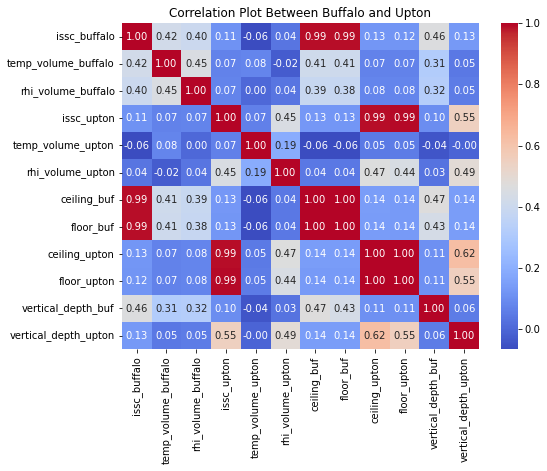

In [20]:
#Plot the entire correlation plot between Buffalo and Upton
plt.figure(figsize = (8,6))
sns.heatmap(combined_df.corr(), annot =True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Plot Between Buffalo and Upton')
plt.show()

## Logisitc Regression for Classiciation

In [21]:
#Was asked to see how predictive an ISSR in one site and it's vertical depth can predict an instance of an ISSR at the other site.
X = combined_df[['issc_buffalo', 'vertical_depth_buf']]
y = combined_df['issc_upton']

In [22]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [23]:
#Assign model as logisitic regression
model = LogisticRegression()

In [24]:
#Fit the x and y training variables into the logisitic regression model
model.fit(X_train, y_train)

LogisticRegression()

In [25]:
#Test the predictive power of the model
y_pred = model.predict(X_test)

In [26]:
#Print accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9452054794520548


In [27]:
#Model statistics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       207
         1.0       0.00      0.00      0.00        12

    accuracy                           0.95       219
   macro avg       0.47      0.50      0.49       219
weighted avg       0.89      0.95      0.92       219



In [28]:
#Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[207,   0],
       [ 12,   0]], dtype=int64)

## Undersampling for Logisitc Regression

In [29]:
#Resample the dataset using under sampling techniques
X_resampled, y_resampled = RandomUnderSampler().fit_resample(X, y)

In [30]:
#Train/ Test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

In [31]:
#Fit new data to logisitic regression model
model.fit(X_train2, y_train2)

LogisticRegression()

In [32]:
#Make predictions
y_pred2 = model.predict(X_test2)

In [33]:
#Print out accuracy
accuracy2 = accuracy_score(y_test2, y_pred2)
print(accuracy2)

0.631578947368421


In [34]:
#Print out confusion matrix
confusion_matrix(y_test2, y_pred2)

array([[10,  2],
       [ 5,  2]], dtype=int64)

## Oversampling for Logisitic Regression

In [35]:
#Resample the dataset using over sampling techniques
X_resampled_over, y_resampled_over = RandomOverSampler().fit_resample(X, y)

In [36]:
#Train/test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_resampled_over, y_resampled_over, test_size = 0.2, random_state = 42)

In [37]:
#Fit new data to logisitic regression model
model.fit(X_train3, y_train3)

LogisticRegression()

In [38]:
#make predictions
y_pred3 = model.predict(X_test3)

In [39]:
#Print accuracy
accuracy3 = accuracy_score(y_test3, y_pred3)
print(accuracy3)

0.6095238095238096


In [40]:
#Print out confusion matrix
confusion_matrix(y_test3, y_pred3)

array([[191,  29],
       [135,  65]], dtype=int64)

## Random Forest Classifier for Classification

In [41]:
#See if Random Forest has better predictive ability
rf_model = RandomForestClassifier(n_estimators = 100, random_state =42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
#Create predictions
y_pred_rf = rf_model.predict(X_test)

In [43]:
#Print Accuracy
accuracy_score(y_test, y_pred_rf)

0.9452054794520548

## Random Forest Classifier with Oversampled Dataset

In [44]:
#Try Random Forest with Oversampled Dataset
rf_model.fit(X_train3, y_train3)

RandomForestClassifier(random_state=42)

In [45]:
#Create Predictions
y_pred_rf3 = rf_model.predict(X_test3)

In [46]:
#Print accuracy
accuracy_score(y_test3, y_pred_rf3)

0.6428571428571429

## Neural Network for Classification using Oversampled Dataset

In [47]:
#Try building a neural network to see it's predictive capability
model = Sequential()

In [48]:
#Input layer
model.add(Dense(units = 64, activation = 'relu', input_dim = X_train3.shape[1]))
#Hidden layer
model.add(Dense(units = 32, activation = 'relu'))
#Output layer
model.add(Dense(units = 1, activation = 'sigmoid'))

In [49]:
#Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [50]:
#Fit oversampled data to neural network model
model.fit(X_train3, y_train3, epochs = 100, batch_size = 32, validation_data = (X_test3, y_test3))

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4871 - loss: 8.6280 - val_accuracy: 0.6095 - val_loss: 0.7971
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5956 - loss: 0.7500 - val_accuracy: 0.5714 - val_loss: 1.0345
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5800 - loss: 1.0428 - val_accuracy: 0.5714 - val_loss: 1.1843
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5768 - loss: 1.1200 - val_accuracy: 0.6095 - val_loss: 0.8182
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5791 - loss: 0.8839 - val_accuracy: 0.6095 - val_loss: 0.8638
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6064 - loss: 0.7311 - val_accuracy: 0.6000 - val_loss: 0.7234
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6018 - loss: 0.9649 - val_accuracy: 0.5714 - val_loss: 0.8569
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5778 - loss: 0.9815 - val_accuracy: 0.5976 - v

In [51]:
#Create predictions with neural network. Create a threshold of 0.5
y_pred_nn = model.predict(X_test3)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred_nn]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [52]:
#Print accuracy
accuracy_score(y_test3, y_pred_binary)

0.6

In [53]:
#Print confusion matrix
confusion_matrix(y_test3, y_pred_binary)

array([[193,  27],
       [141,  59]], dtype=int64)

## Adjusting Neural Network

In [169]:
# Define the number of splits for K-Fold
n_splits = 5

# Prepare K-fold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# To store scores for each fold
scores = []

def create_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_shape),  # Adjust the number of neurons or layers as needed
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Adjust according to your output. For classification use 'sigmoid'
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [170]:
# Iterate over each fold
for train_index, test_index in kf.split(X_resampled_over):
    # Split data into training and test sets for the current fold
    X_train_fold = X_resampled_over.iloc[train_index]
    X_test_fold = X_resampled_over.iloc[test_index]
    y_train_fold = y_resampled_over.iloc[train_index]
    y_test_fold = y_resampled_over.iloc[test_index]
    
    # Create model
    model = create_model(X_train_fold.shape[1])
    
    # Fit the model
    model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_fold, y_test_fold))
    
    # Evaluate the model on the test fold
    _, accuracy = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    scores.append(accuracy)

# Calculate average accuracy across all folds
average_accuracy = np.mean(scores)
print("Average accuracy across all folds: ", average_accuracy)


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5901 - loss: 6.0399 - val_accuracy: 0.6095 - val_loss: 1.2881
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5845 - loss: 5.3249 - val_accuracy: 0.6095 - val_loss: 1.8429
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5966 - loss: 3.4391 - val_accuracy: 0.6095 - val_loss: 2.1890
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5931 - loss: 2.2145 - val_accuracy: 0.6095 - val_loss: 0.9519
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5934 - loss: 2.2392 - val_accuracy: 0.6095 - val_loss: 1.2457
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5979 - loss: 1.9173 - val_accuracy: 0.6095 - val_loss: 0.8390
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5956 - loss: 1.5191 - val_accuracy: 0.6095 - val_loss: 0.7022
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5889 - loss: 1.0346 - val_accuracy: 0.5714 - v

## Modeling with SMOTE

In [102]:
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X, y)

### Neural Network

In [103]:
#Try building a neural network to see it's predictive capability
model = Sequential()

In [104]:
#Input layer
model.add(Dense(units = 64, activation = 'relu', input_dim = X_train3.shape[1]))
#Hidden layer
model.add(Dense(units = 32, activation = 'relu'))
#Output layer
model.add(Dense(units = 1, activation = 'sigmoid'))

In [105]:
#Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [106]:
#Fit SMOTE data to neural network model
model.fit(X_train_smote, y_train_smote, epochs = 100, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5466 - loss: 3.8796 - val_accuracy: 0.8356 - val_loss: 2.0611
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5645 - loss: 1.0107 - val_accuracy: 0.8767 - val_loss: 0.6498
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5742 - loss: 0.9293 - val_accuracy: 0.8767 - val_loss: 0.6263
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5989 - loss: 0.7785 - val_accuracy: 0.8767 - val_loss: 0.6257
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5685 - loss: 1.2637 - val_accuracy: 0.8402 - val_loss: 1.1517
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5886 - loss: 0.9747 - val_accuracy: 0.8447 - val_loss: 0.8099
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6051 - loss: 1.0017 - val_accuracy: 0.8356 - val_loss: 2.6970
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5939 - loss: 1.2403 - val_accuracy: 0.8447 - v

In [107]:
#Create predictions with neural network. Create a threshold of 0.5
y_pred_nn = model.predict(X_test)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred_nn]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [108]:
#Print accuracy
accuracy_score(y_test, y_pred_binary)

0.867579908675799

In [109]:
#Print confusion matrix
confusion_matrix(y_test, y_pred_binary)

array([[189,  18],
       [ 11,   1]], dtype=int64)

In [110]:
smote_params = {
    'k_neighbors': [3, 5, 7],
    'sampling_strategy': ['auto', 0.5, 0.75, 1.0]}

# Best score initialization
best_accuracy = 0
best_params = {}

# Generate all combinations of SMOTE parameters
for k_neighbors, sampling_strategy in product(smote_params['k_neighbors'], smote_params['sampling_strategy']):
    # Apply SMOTE
    smote = SMOTE(k_neighbors=k_neighbors, sampling_strategy=sampling_strategy, random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Build and compile the model
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train_smote.shape[1]),  # input layer
        Dense(32, activation='relu'),  # hidden layer
        Dense(1, activation='sigmoid')  # output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_smote, y_train_smote, epochs=100, batch_size=32, verbose=0)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Save parameters if they improve the score
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'k_neighbors': k_neighbors, 'sampling_strategy': sampling_strategy}

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Best Accuracy: 0.8767123287671232
Best Parameters: {'k_neighbors': 3, 'sampling_strategy': 'auto'}


In [111]:
smote2 = SMOTE(k_neighbors = 3, sampling_strategy = 'auto', random_state = 42)

X_train_smote2, y_train_smote2 = smote2.fit_resample(X, y)

In [153]:
#Try building a neural network to see it's predictive capability
model = Sequential()

#Input layer
model.add(Dense(units = 64, activation = 'relu', input_dim = X_train_smote2.shape[1]))
#Hidden layer
model.add(Dense(units = 32, activation = 'relu'))
#Output layer
model.add(Dense(units = 1, activation = 'sigmoid'))

#Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#Fit SMOTE data to neural network model
model.fit(X_train_smote2, y_train_smote2, epochs = 100, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5837 - loss: 1.7850 - val_accuracy: 0.8356 - val_loss: 1.6102
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5819 - loss: 1.2725 - val_accuracy: 0.8356 - val_loss: 3.2012
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5723 - loss: 1.3202 - val_accuracy: 0.8767 - val_loss: 0.6122
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5632 - loss: 1.0444 - val_accuracy: 0.8356 - val_loss: 2.4796
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5886 - loss: 1.3004 - val_accuracy: 0.8356 - val_loss: 1.4178
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5878 - loss: 0.8924 - val_accuracy: 0.8767 - val_loss: 0.6496
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5982 - loss: 1.2816 - val_accuracy: 0.8767 - val_loss: 0.6169
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5883 - loss: 1.2428 - val_accuracy: 0.8356 - v

In [154]:
#Create predictions with neural network. Create a threshold of 0.5
y_pred_nn = model.predict(X_test)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred_nn]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [155]:
#Print accuracy
accuracy_score(y_test, y_pred_binary)

0.8447488584474886

In [156]:
#Print confusion matrix
confusion_matrix(y_test, y_pred_binary)

array([[183,  24],
       [ 10,   2]], dtype=int64)